# keras 函数api

In [1]:
!pip install pydot
# !sudo apt-get install graphvizf

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 71kB 4.6MB/s 


In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
tf.keras.backend.clear_session()

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 1构建简单的网络
### 1.1创建网络

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 784)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________
******************************************************************************************************************************************************


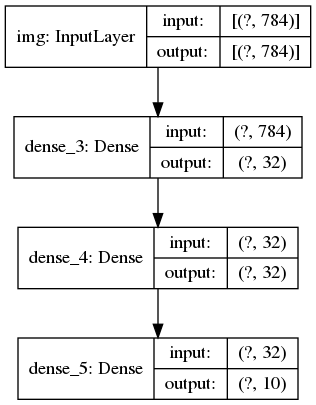

In [4]:

inputs = tf.keras.Input(shape=(784,), name='img')
h1 = layers.Dense(32, activation='relu')(inputs)
h2 = layers.Dense(32, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h2)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')

model.summary()
keras.utils.plot_model(model, 'mnist_model.png')
print('***'*50)
keras.utils.plot_model(model, 'model_info.png', show_shapes=True)

### 1.2训练、验证及测试

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') /255
x_test = x_test.reshape(10000, 784).astype('float32') /255
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss='sparse_categorical_crossentropy', # 直接填api，后面会报错
             metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.2)
test_scores = model.evaluate(x_test, y_test, verbose=0)
print('test loss:', test_scores[0])
print('test acc:', test_scores[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 2s 51us/sample - loss: 0.4308 - accuracy: 0.8794 - val_loss: 0.2272 - val_accuracy: 0.9342
Epoch 2/5
48000/48000 [==============================] - 2s 37us/sample - loss: 0.2061 - accuracy: 0.9405 - val_loss: 0.1931 - val_accuracy: 0.9435
Epoch 3/5
48000/48000 [==============================] - 2s 36us/sample - loss: 0.1663 - accuracy: 0.9514 - val_loss: 0.1632 - val_accuracy: 0.9528
Epoch 4/5
48000/48000 [==============================] - 2s 38us/sample - loss: 0.1394 - accuracy: 0.9581 - val_loss: 0.1453 - val_accuracy: 0.9568
Epoch 5/5
48000/48000 [==============================] - 2s 36us/sample - loss: 0.1219 - accuracy: 0.9641 - val_loss: 0.1384 - val_accuracy: 0.9608
test loss: 0.13192606419175865
test acc: 0.9593


### 1.3模型保持和序列化

In [5]:
model.save('model_save.h5')
del model
model = keras.models.load_model('model_save.h5')

## 2 使用共享网络创建多个模型
在函数API中，通过在图层图中指定其输入和输出来创建模型。 这意味着可以使用单个图层图来生成多个模型。

In [7]:
# 编码器网络和自编码器网络

encode_input = keras.Input(shape=(28,28,1), name='img')
h1 = layers.Conv2D(16, 3, activation='relu')(encode_input)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.MaxPool2D(3)(h1)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.Conv2D(16, 3, activation='relu')(h1)
encode_output = layers.GlobalMaxPool2D()(h1)

encode_model = keras.Model(inputs=encode_input, outputs=encode_output, name='encoder')
encode_model.summary()

h2 = layers.Reshape((4, 4, 1))(encode_output)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
h2 = layers.Conv2DTranspose(32, 3, activation='relu')(h2)
h2 = layers.UpSampling2D(3)(h2)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
decode_output = layers.Conv2DTranspose(1, 3, activation='relu')(h2)

autoencoder = keras.Model(inputs=encode_input, outputs=decode_output, name='autoencoder')
autoencoder.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

可以把整个模型，当作一层网络使用

In [8]:
encode_input = keras.Input(shape=(28,28,1), name='src_img')
h1 = layers.Conv2D(16, 3, activation='relu')(encode_input)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.MaxPool2D(3)(h1)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.Conv2D(16, 3, activation='relu')(h1)
encode_output = layers.GlobalMaxPool2D()(h1)

encode_model = keras.Model(inputs=encode_input, outputs=encode_output, name='encoder')
encode_model.summary()

decode_input = keras.Input(shape=(16,), name='encoded_img')
h2 = layers.Reshape((4, 4, 1))(decode_input)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
h2 = layers.Conv2DTranspose(32, 3, activation='relu')(h2)
h2 = layers.UpSampling2D(3)(h2)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
decode_output = layers.Conv2DTranspose(1, 3, activation='relu')(h2)
decode_model = keras.Model(inputs=decode_input, outputs=decode_output, name='decoder')
decode_model.summary()

autoencoder_input = keras.Input(shape=(28,28,1), name='img')
h3 = encode_model(autoencoder_input)
autoencoder_output = decode_model(h3)
autoencoder = keras.Model(inputs=autoencoder_input, outputs=autoencoder_output,
                          name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
src_img (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 16)                0   

## 3.复杂网络结构构建
### 3.1多输入与多输出网络

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
body (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     128000      title[0][0]                      
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     128000      body[0][0]                       
______________________________________________________________________________________________

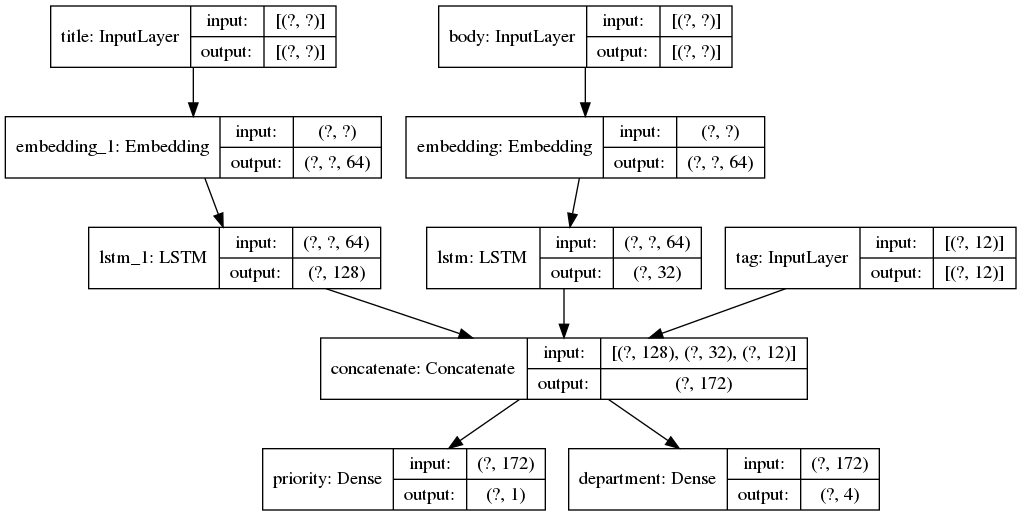

In [2]:
# 构建一个根据文档内容、标签和标题，预测文档优先级和执行部门的网络
# 超参
num_words = 2000
num_tags = 12
num_departments = 4

# 输入
body_input = keras.Input(shape=(None,), name='body')
title_input = keras.Input(shape=(None,), name='title')
tag_input = keras.Input(shape=(num_tags,), name='tag')

# 嵌入层
body_feat = layers.Embedding(num_words, 64)(body_input)
title_feat = layers.Embedding(num_words, 64)(title_input)

# 特征提取层
body_feat = layers.LSTM(32)(body_feat)
title_feat = layers.LSTM(128)(title_feat)
features = layers.concatenate([title_feat,body_feat, tag_input])

# 分类层
priority_pred = layers.Dense(1, activation='sigmoid', name='priority')(features)
department_pred = layers.Dense(num_departments, activation='softmax', name='department')(features)


# 构建模型
model = keras.Model(inputs=[body_input, title_input, tag_input],
                    outputs=[priority_pred, department_pred])
model.summary()
keras.utils.plot_model(model, 'multi_model.png', show_shapes=True)

In [3]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss={'priority': 'binary_crossentropy',
                  'department': 'categorical_crossentropy'},
             loss_weights=[1., 0.2])

import numpy as np
# 载入输入数据
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tag_data = np.random.randint(2, size=(1280, num_tags)).astype('float32')
# 标签
priority_label = np.random.random(size=(1280, 1))
department_label = np.random.randint(2, size=(1280, num_departments))
# 训练
history = model.fit(
    {'title': title_data, 'body':body_data, 'tag':tag_data},
    {'priority':priority_label, 'department':department_label},
    batch_size=32,
    epochs=4
)

Train on 1280 samples
Epoch 1/4
1280/1280 [==============================] - 4s 3ms/sample - loss: 1.2717 - priority_loss: 0.7065 - department_loss: 2.8260
Epoch 2/4
1280/1280 [==============================] - 1s 391us/sample - loss: 1.2664 - priority_loss: 0.6993 - department_loss: 2.8357
Epoch 3/4
1280/1280 [==============================] - 0s 342us/sample - loss: 1.2607 - priority_loss: 0.6951 - department_loss: 2.8278
Epoch 4/4
1280/1280 [==============================] - 0s 339us/sample - loss: 1.2622 - priority_loss: 0.6982 - department_loss: 2.8203


### 3.2小型残差网络

Model: "small resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 9, 9, 64)     0           conv2d_1[0][0]                   
_______________________________________________________________________________________

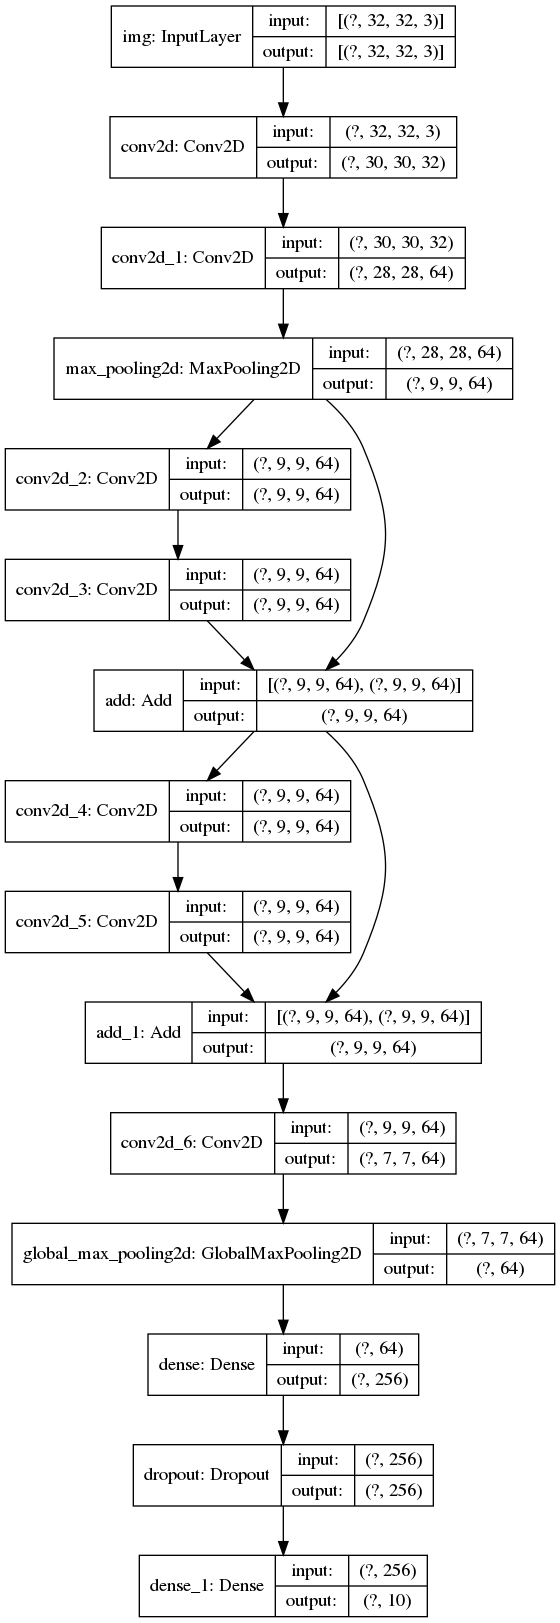

In [4]:
inputs = keras.Input(shape=(32,32,3), name='img')
h1 = layers.Conv2D(32, 3, activation='relu')(inputs)
h1 = layers.Conv2D(64, 3, activation='relu')(h1)
block1_out = layers.MaxPooling2D(3)(h1)

h2 = layers.Conv2D(64, 3, activation='relu', padding='same')(block1_out)
h2 = layers.Conv2D(64, 3, activation='relu', padding='same')(h2)
block2_out = layers.add([h2, block1_out])

h3 = layers.Conv2D(64, 3, activation='relu', padding='same')(block2_out)
h3 = layers.Conv2D(64, 3, activation='relu', padding='same')(h3)
block3_out = layers.add([h3, block2_out])

h4 = layers.Conv2D(64, 3, activation='relu')(block3_out)
h4 = layers.GlobalMaxPool2D()(h4)
h4 = layers.Dense(256, activation='relu')(h4)
h4 = layers.Dropout(0.5)(h4)
outputs = layers.Dense(10, activation='softmax')(h4)

model = keras.Model(inputs, outputs, name='small resnet')
model.summary()
keras.utils.plot_model(model, 'small_resnet_model.png', show_shapes=True)


In [26]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = y_train.astype('float32') / 255
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss='categorical_crossentropy',
             metrics=['acc'])
model.fit(x_train, y_train,
         batch_size=64,
         epochs=1,
         validation_split=0.2)

#model.predict(x_test, batch_size=32)

Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 85s 2ms/sample - loss: 1.4249 - acc: 0.4866 - val_loss: 1.2088 - val_acc: 0.5632


## 4.共享网络层

Model: "small_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     64000       input_3[0][0]                    
                                                                 input_4[0][0]                    
Total params: 64,000
Trainable params: 64,000
Non-trainable params: 0
__________________________________________________________________________________________________


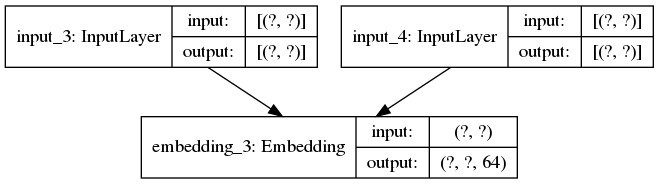

In [6]:
share_embedding = layers.Embedding(1000, 64)

input1 = keras.Input(shape=(None,), dtype='int32')
input2 = keras.Input(shape=(None,), dtype='int32')

feat1 = share_embedding(input1)
feat2 = share_embedding(input2)

model = keras.Model(inputs=[input1, input2], outputs=[feat1, feat2], name='small_resnet')
model.summary()
keras.utils.plot_model(model, 'small_resnet_model.png', show_shapes=True)

## 5.模型复用

In [ ]:
from tensorflow.keras.applications import VGG16
vgg16=VGG16()

feature_list = [layer.output for layer in vgg16.layers]
feat_ext_model = keras.Model(inputs=vgg16.input, outputs=feature_list)

img = np.random.random((1, 224, 224, 3).astype('float32'))
ext_features = feat_ext_model(img)

## 6.自定义网络层

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
my_dense_4 (MyDense)         (None, 10)                50        
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________


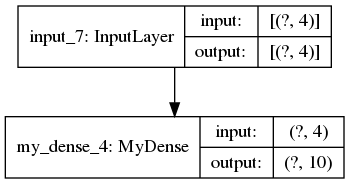

In [9]:
# import tensorflow as tf
# import tensorflow.keras as keras
class MyDense(layers.Layer):
    def __init__(self, units=32):
        super(MyDense, self).__init__()
        self.units = units
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
    def get_config(self):
        return {'units': self.units}
    
inputs = keras.Input((4,))
outputs = MyDense(10)(inputs)
model = keras.Model(inputs, outputs)
config = model.get_config()
new_model = keras.Model.from_config(config, custom_objects={'MyDense':MyDense})

model.summary()
keras.utils.plot_model(model, 'small_resnet_model.png', show_shapes=True)


(32, 8, 32)
(32, 8, 32)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(32, 10, 5)]             0         
_________________________________________________________________
conv1d (Conv1D)              (32, 8, 32)               512       
_________________________________________________________________
my_rnn (MyRnn)               (32, 8, 1)                2145      
Total params: 2,657
Trainable params: 2,657
Non-trainable params: 0
_________________________________________________________________


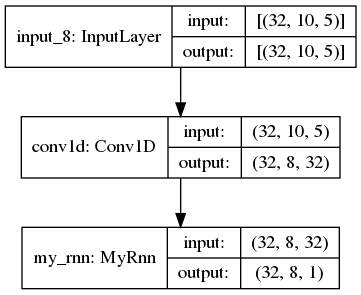

In [10]:
# 在自定义网络层调用其他网络层

# 超参
time_step = 10
batch_size = 32
hidden_dim = 32
inputs_dim = 5

# 网络
class MyRnn(layers.Layer):
    def __init__(self):
        super(MyRnn, self).__init__()
        self.hidden_dim = hidden_dim
        self.projection1 = layers.Dense(units=hidden_dim, activation='relu')
        self.projection2 = layers.Dense(units=hidden_dim, activation='relu')
        self.classifier = layers.Dense(1, activation='sigmoid')
    def call(self, inputs):
        outs = []
        states = tf.zeros(shape=[inputs.shape[0], self.hidden_dim])
        for t in range(inputs.shape[1]):
            x = inputs[:,t,:]
            h = self.projection1(x)
            y = h + self.projection2(states)
            states = y
            outs.append(y)
        # print(outs)
        features = tf.stack(outs, axis=1)
        print(features.shape)
        return self.classifier(features)

# 构建网络
inputs = keras.Input(batch_shape=(batch_size, time_step, inputs_dim))
x = layers.Conv1D(32, 3)(inputs)
print(x.shape)
outputs = MyRnn()(x)
model = keras.Model(inputs, outputs)

model.summary()
keras.utils.plot_model(model, 'small_resnet_model.png', show_shapes=True)


Model: "small resnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1327360   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

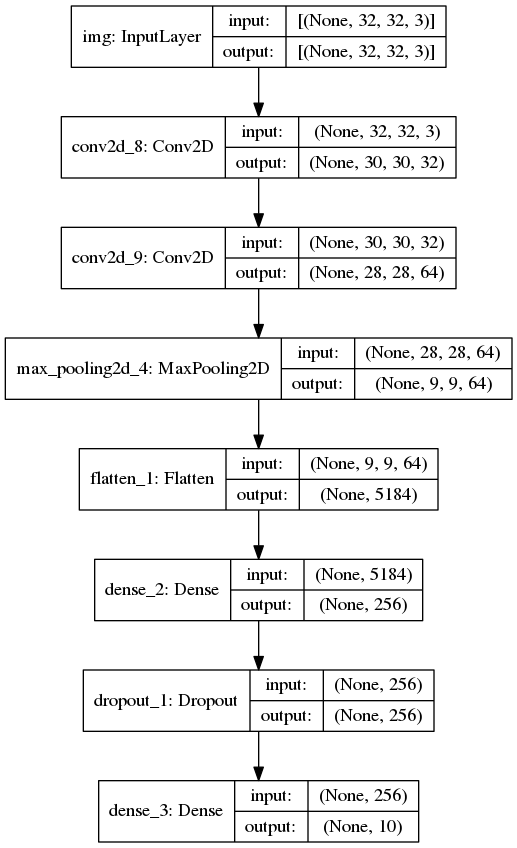

In [5]:
# 简单的卷积神经网络

from __future__ import absolute_import, division, print_function
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
inputs = keras.Input(shape=(32,32,3), name='img')
h1 = layers.Conv2D(32, 3, activation='relu')(inputs)
h2 = layers.Conv2D(64, 3, activation='relu')(h1)
h3 = layers.MaxPooling2D(3)(h2)
h3 = layers.Flatten()(h3)
h4 = layers.Dense(256, activation='relu')(h3)
h4 = layers.Dropout(0.5)(h4)
outputs = layers.Dense(10, activation='softmax')(h4)

model = keras.Model(inputs, outputs, name='small resnet')
model.summary()
keras.utils.plot_model(model, 'small_resnet_model.png', show_shapes=True)



In [ ]:
keras.layers.GlobalMaxPool1D
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = y_train.astype('float32') / 255
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss='categorical_crossentropy',
             metrics=['acc'])
model.fit(x_train, y_train,
         batch_size=64,
         epochs=1,
         validation_split=0.2)

#model.predict(x_test, batch_size=32)
